In [1]:
import tensorflow as tf
import numpy as np
import Censai as Celi
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
execfile('lensmodel_source.py')

Using RNN
Tensor("sub_1:0", shape=(?, 192, 192, 1), dtype=float32) <iterative_inference_learning.layers.rnn_cell.MultiRNNCellFlex object at 0x1a224bc710> <iterative_inference_learning.layers.loopfun.InputFunction object at 0x1a224e4550> <iterative_inference_learning.layers.loopfun.OutputFunction object at 0x1a224e4710> <function init_func at 0x1a224ddd70> Tensor("T:0", shape=(), dtype=int32)
3 1 Tensor("RNN/stack_2:0", shape=(?, 192, 192, 1), dtype=float32)
3 1 Tensor("RNN/while/stack_2:0", shape=(?, 192, 192, 1), dtype=float32)
xold is  Tensor("RNN/while/Identity_3:0", shape=(?, 192, 192, 2), dtype=float32)
xout is  Tensor("RNN/while/Conv/Conv2D:0", shape=(?, 192, 192, 2), dtype=float32)
INFO:tensorflow:Restoring parameters from /Users/llevasseur/Documents/travail/Censai/trained_weights/RIM_source/MagNet_hires_chi2.ckpt
Sampling data
Iterating...
0
generated data batch 0
(1, 192, 192, 1)
(1, 192, 192, 1)
DONE
Optimization Finished!


SystemExit: 

/Users/llevasseur/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
source_image = np.load('source_image.npy')
source_image_true = np.load('source_image_true.npy')

source_image.shape

(1, 192, 192, 1)

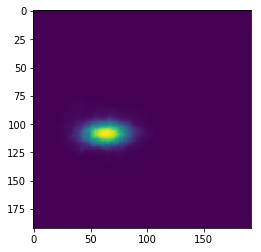

In [4]:
plt.imshow(source_image[0,:,:,0])


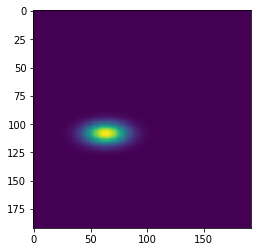

In [5]:
plt.imshow(source_image_true[0,:,:,0])

In [6]:
last_grad=np.load('last_grad.npy')
true_data=np.load('true_data.npy')

kappa = np.load('kappa_map.npy')

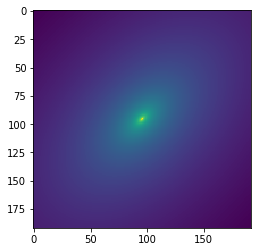

In [7]:
plt.imshow(np.log10(kappa[0,:,:,0]))

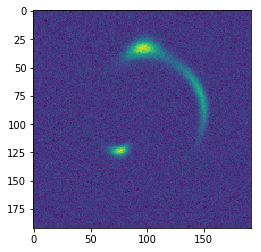

In [8]:
plt.imshow(true_data[0,:,:,0])

In [ ]:
# plt.imshow(source_image[0,:,:,0])
plt.imshow(last_grad[0,:,:,0])

In [ ]:
last_grad.shape

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string('train_dir', '~/Documents/tensorflow_logs/iel/',
                           """Directory where to write event logs """
                           """and checkpoint.""")
tf.app.flags.DEFINE_boolean('use_rnn', True,
                            """Flag whether to use an RNN or whether to use a ReLu network.""")
tf.app.flags.DEFINE_boolean('use_gray', True,
                            """Flag whether we work on gray images or RGB images.""")
tf.app.flags.DEFINE_boolean('use_grad', True,
                            """Flag whether to use gradient information in the inference model""")
tf.app.flags.DEFINE_boolean('use_prior', True,
                            """Flag whether to input the current estimate again.""")
tf.app.flags.DEFINE_boolean('accumulate_output', True,
                            """Flag whether some teh network outputs over time.""")
tf.app.flags.DEFINE_float('lr', 1.5e-5,
                            """Global learning rate to use""")
tf.app.flags.DEFINE_integer('n_pseudo', 1,
                            """How many pseudo samples should be used""")
tf.app.flags.DEFINE_integer('n_epochs', 10,
                            """Number of epochs.""")
tf.app.flags.DEFINE_boolean('log_device_placement', False,
                            """Whether to log device placement.""")
tf.app.flags.DEFINE_integer('k_size', 11,
                            """Size of convolutional kernels.""")
tf.app.flags.DEFINE_integer('features', 32,
                            """Number of features per layer.""")
tf.app.flags.DEFINE_integer('depth', 1,
                            """Depth of the network""")
tf.app.flags.DEFINE_integer('batch_size', 5,
                            """Number of samples per batch.""")
tf.app.flags.DEFINE_integer('t_max', 10,
                            """The number of time steps to train on. """
                            """If -1 it will be drawn randomly from a geometrix distribution.""")
tf.app.flags.DEFINE_integer('j_min', 6,
                            """The minimum id of corruption models to sample from""")
tf.app.flags.DEFINE_integer('j_max', 7,
                            """The maximum id of corruption models to sample from""")
tf.app.flags.DEFINE_integer('k_max', 5,
                            """The maximum size x of corruption kernels for BlurImage, and pooling size """
                            """ for resize operations """)
tf.app.flags.DEFINE_integer('k_in', 1,
                            """The number of input channels of corruption kernels for BlurImage""")
tf.app.flags.DEFINE_integer('k_out', 1,
                            """The number of output channels corruption kernels for BlurImage, and pooling size""")
tf.app.flags.DEFINE_integer('stride', 1,
                            """The stride for the ImageBlur operation""")
tf.app.flags.DEFINE_float('noise_lambda', 100.,
                            """The scale parameter for the exponential distribution where """
                            """noise_std is drawn from.""")
tf.app.flags.DEFINE_float('reduction_min', 0.,
                            """The minimum allowable fraction of sample size fro RP""")
tf.app.flags.DEFINE_float('reduction_max', 1.,
                            """The maximum allowable fraction of sample size fro RP""")
tf.app.flags.DEFINE_string('desc', 'default_superres_model_',
                           """A short description of the experiment""")

In [ ]:
Raytracer = Celi.Likelihood(numpix_side = 192)

In [ ]:
Datagen = Celi.DataGenerator(numpix_side=Raytracer.numpix_side, numkappa_side=193, src_side=Raytracer.src_side, im_side = Raytracer.im_side,max_noise_rms=0.0,use_psf=False,lens_model_error=[0.01,0.01,0.01,0.01,0.01,0.01,0.01],binpix=1,mask=False,min_unmasked_flux=1.0)

In [ ]:
batch_size = 2
n_channel = 1

Datagen.X = np.zeros((batch_size, Datagen.numpix_side , Datagen.numpix_side,1 ))
Datagen.source = np.zeros((batch_size, Datagen.numpix_side , Datagen.numpix_side,1 ))
Datagen.kappa = np.zeros((batch_size, Datagen.numkappa_side , Datagen.numkappa_side,1 ))
max_file_num=None
train_or_test = 'train'
read_or_gen = 'gen'

In [ ]:
Datagen.read_data_batch(Datagen.X ,Datagen.source , train_or_test, read_or_gen)

In [ ]:
Kappatest = tf.placeholder( tf.float32, [None, Datagen.numkappa_side, Datagen.numkappa_side,1] )
Srctest = tf.placeholder( tf.float32, [None, Raytracer.numpix_side, Raytracer.numpix_side,1] )



y_ = tf.placeholder(dtype=tf.float32,shape=[None,Datagen.numkappa_side**2])
y_image = Kappatest
x_init = tf.zeros_like(y_image)



Raytracer.trueimage = Raytracer.get_lensed_image(Kappatest,[0.,0.], 7.68, Srctest)
x_image = Raytracer.trueimage


n_channel = 1


#imout= sess.run(IM, feed_dict={Srctest: Datagen.source, Kappatest: Datagen.kappa})

In [ ]:
# Needed for Optimization purposes
global_step = tf.Variable(0, trainable=False, dtype=tf.int32)
is_training = tf.placeholder(tf.bool, [], name='is_training')

# Number of steps to perform for inference
T = tf.constant(FLAGS.t_max, dtype=tf.int32, name='T')


In [ ]:
print imout.shape

In [ ]:
plt.imshow(imout[1,:,:,0])

In [ ]:
Datagen.numkappa_side

In [ ]:
3.0/(191)